# Direct multi-step forecaster

This strategy, commonly known as direct multistep forecasting, is computationally more expensive than the recursive since it requires training several models. However, in some scenarios, it achieves better results. This type of model can be obtained with the `ForecasterAutoregDirect` class and can also include one or multiple exogenous variables.


Direct multi-step forecasting is a time series forecasting strategy in which a separate model is trained to predict each step in the forecast horizon. This is in contrast to recursive multi-step forecasting, where a single model is used to make predictions for all future time steps by recursively using its own output as input.

Direct multi-step forecasting can be more computationally expensive than recursive forecasting since it requires training multiple models. However, it can often achieve better accuracy in certain scenarios, particularly when there are complex patterns and dependencies in the data that are difficult to capture with a single model.

Direct multi-step forecasting can be performed using the `ForecasterAutoregDirect` class, which can also incorporate one or multiple exogenous variables to improve the accuracy of the forecasts.

<p align="center"><img src="../img/diagram-direct-multi-step-forecasting.png" style="width: 700px"></p>

<center><font size="2.5"> <i>Diagram of direct multi-step forecasting.</i></font></center>


To train a `ForecasterAutoregDirect` a different training matrix is created for each model.


<p align="center"><img src="../img/diagram_skforecast_multioutput.png" style="width: 700px"></p>

<center><font size="2.5"> <i>Transformation of a time series into matrices to train a direct multi-step forecasting model.</i></font></center>

## Libraries

In [1]:
# Libraries
# ==============================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

## Data

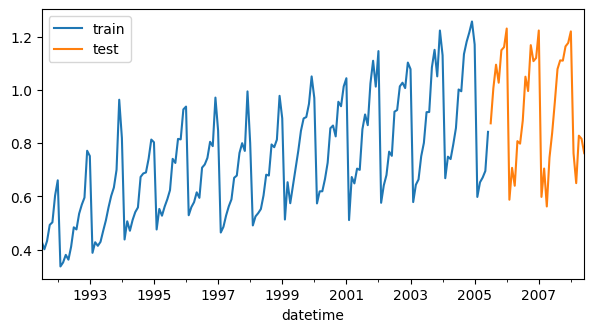

In [2]:
# Download data
# ==============================================================================
url = ('https://raw.githubusercontent.com/JoaquinAmatRodrigo/skforecast/master/data/h2o.csv')
data = pd.read_csv(url, sep=',', header=0, names=['y', 'datetime'])

# Data preprocessing
# ==============================================================================
data['datetime'] = pd.to_datetime(data['datetime'], format='%Y/%m/%d')
data = data.set_index('datetime')
data = data.asfreq('MS')
data = data['y']
data = data.sort_index()

# Split train-test
# ==============================================================================
steps = 36
data_train = data[:-steps]
data_test  = data[-steps:]

# Plot
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
ax.legend();

## Create and train forecaster

In [3]:
# Create and fit forecaster
# ==============================================================================
forecaster = ForecasterAutoregDirect(
                 regressor = Ridge(),
                 steps     = 36,
                 lags      = 15
             )

forecaster.fit(y=data_train)
forecaster

ForecasterAutoregDirect 
Regressor: Ridge() 
Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15] 
Transformer for y: None 
Transformer for exog: None 
Weight function included: False 
Window size: 15 
Maximum steps predicted: 36 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1991-07-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': None, 'solver': 'auto', 'tol': 0.0001} 
Creation date: 2023-03-31 11:20:11 
Last fit date: 2023-03-31 11:20:11 
Skforecast version: 0.7.1 
Python version: 3.10.9 
Forecaster id: None 

## Prediction

When predicting, the value of `steps` must be less than or equal to the value of steps defined when initializing the forecaster. Starts at 1.

+ If `int` only steps within the range of 1 to int are predicted.

+ If `list` of `int`. Only the steps contained in the list are predicted.

+ If `None` as many steps are predicted as were defined at initialization.

In [4]:
# Predict
# ==============================================================================
predictions = forecaster.predict()
print('As many steps are predicted as have been defined in the initialization.')
display(predictions.head(3))

predictions = forecaster.predict(steps=[1, 5])
print('')
print('Only the steps contained in the list are predicted.')
display(predictions)

As many steps are predicted as have been defined in the initialization.


2005-07-01    0.952051
2005-08-01    1.004145
2005-09-01    1.114590
Name: pred, dtype: float64


Only the steps contained in the list are predicted.


2005-07-01    0.952051
2005-11-01    1.179922
Name: pred, dtype: float64

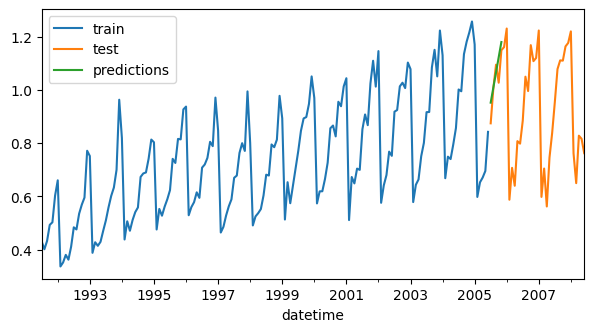

In [5]:
# Plot predictions
# ==============================================================================
fig, ax=plt.subplots(figsize=(7, 3.5))
data_train.plot(ax=ax, label='train')
data_test.plot(ax=ax, label='test')
predictions.plot(ax=ax, label='predictions')
ax.legend();

In [6]:
# Prediction error
# ==============================================================================
predictions = forecaster.predict(steps=36)

error_mse = mean_squared_error(
                y_true = data_test,
                y_pred = predictions
            )
            
print(f"Test error (mse): {error_mse}")

Test error (mse): 0.00841959727883196


## Feature importances

Since `ForecasterAutoregDirect` fits one model per step, it is necessary to specify from which model retrieves its feature importances.

In [7]:
forecaster.get_feature_importances(step=1)

,feature,importance
0,lag_1,0.139299
1,lag_2,0.051089
2,lag_3,0.044192
3,lag_4,-0.019868
4,lag_5,-0.017935
5,lag_6,-0.013233
6,lag_7,-0.021063
7,lag_8,-0.012591
8,lag_9,0.011918
9,lag_10,0.020511


## Extract training matrices

Two steps are needed to extract the training matrices. One to create the whole training matrix and a second one to subset the data needed for each model (step).

In [8]:
# Create the whole train matrix
X, y = forecaster.create_train_X_y(data_train)

# Extract X and y to train the model for step 1
X_1, y_1 = forecaster.filter_train_X_y_for_step(
               step    = 1,
               X_train = X,
               y_train = y,
           )

X_1.head(4)

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15
datetime,,,,,,,,,,,,,,,
1995-09-01,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906,0.429795
1995-10-01,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159,0.400906
1995-11-01,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543,0.432159
1995-12-01,0.771258,0.595223,0.568606,0.534761,0.475463,0.483389,0.410534,0.361801,0.379808,0.351348,0.336220,0.660119,0.602652,0.502369,0.492543


In [9]:
y_1.head(4)

datetime
1995-09-01    0.568606
1995-10-01    0.595223
1995-11-01    0.771258
1995-12-01    0.751503
Freq: MS, Name: y_step_1, dtype: float64

In [10]:
%%html
<style>
.jupyter-wrapper .jp-CodeCell .jp-Cell-inputWrapper .jp-InputPrompt {display: none;}
</style>